# Non cartesian sampling: SPARKLING imaging
We explore the performance of SPARKLING (_Spreading projection Algorithm for Rapid K-space sampLING_) as non-Cartesian imaging technique. We do not actually provide the code of this algorithm but instead upload result files containing trajectories generated from the previous *radial in-out* initialization. For details, see the recently published paper: Lazarus et al, "SPARKLING: variable‐density k‐space filling curves for accelerated $T_2^*$ ‐weighted MRI", Magn Reson Med 2019; 81:3643:3661. 
* Authors: Philippe Ciuciu (philippe.ciuciu@cea.fr), Nicolas Chartier.
* Original Sparkling code developed by: Carole Lazarus, Nicolas Chauffert and Pierre Weiss
* Date: 04/05/2019
* Target: ISBI'19 tutorial on Recent advances in acquisition and reconstruction for Compressed Sensing MRI

<IPython.core.display.Javascript object>


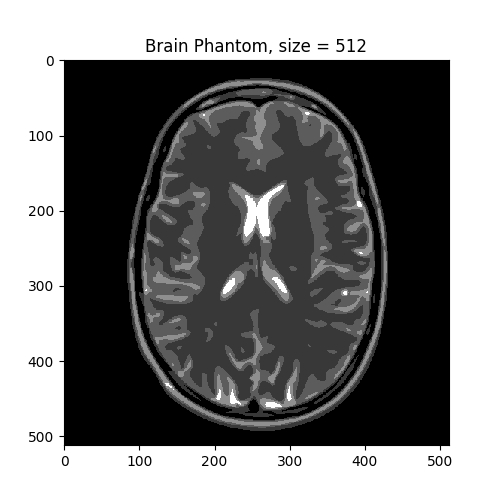

In [7]:
#DISPLAY BRAIN PHANTOM
%matplotlib nbagg

import numpy as np
import os.path as op
import os
import math ; import cmath
import matplotlib
import matplotlib.pyplot as plt
import sys

from skimage import data, img_as_float, io, filters
from skimage.measure import compare_ssim as ssim

#get current working dir

cwd = os.getcwd()
dirimg_2d = op.join(cwd,"..","data")
img_size = 512   #256
FOV = 0.2 #field of view in meters
pixelSize = FOV/img_size

#load data file corresponding to the target resolution
filename = "BrainPhantom" + str(img_size) + ".png"
mri_filename = op.join(dirimg_2d, filename)
mri_img = io.imread(mri_filename, as_gray=True)
or_image = plt.figure(figsize=(5,5))
plt.title("Brain Phantom, size = "+ str(img_size))
if mri_img.ndim == 2:
    plt.imshow(mri_img, cmap=plt.cm.gray)
else:
    plt.imshow(mri_img)
plt.show()

In [13]:
#PARAMETERS AND CONSTRAINTS
from collections import namedtuple

samplingOptions = namedtuple("samplingOptions", "nc ns OS_factor decim tau decay mask iter init Kmax Smax Gmax gamma dTime n_revol n_epi")

#nc is the number of shots in the k-space
#ns is the number of gradient samples per shot
#Oversampling factor = (gradient raster time)/(gradient dwell time)
#Kmax depends of FOV and image resolution (NS criterion)
#Gmax and Smax : maximum gradient (T/m) and slew rate (T/m/ms)
#tau, decay and mask parametrize the sampling density (mask=1 for circular - isotrope kspace - 0 otherwise)
#iter = number of iterations (gradient descent steps?)
#mask = initialization for SPARKLING (radial in-out, radial center-out, spiral in-out...)
#gamma = gyromagnetic constant (Hz/T)

samplingOptions.nc = 34
samplingOptions.ns = 3073
samplingOptions.OS_factor = 1
samplingOptions.decim = 1

samplingOptions.Kmax = img_size/(2*FOV)
samplingOptions.Gmax = 40e-3
samplingOptions.Smax = 200e-3

samplingOptions.gamma = 42.576e3 ; samplingOptions.dTime = 0.010 #in ms

samplingOptions.n_revol = 1

1280.0


<IPython.core.display.Javascript object>


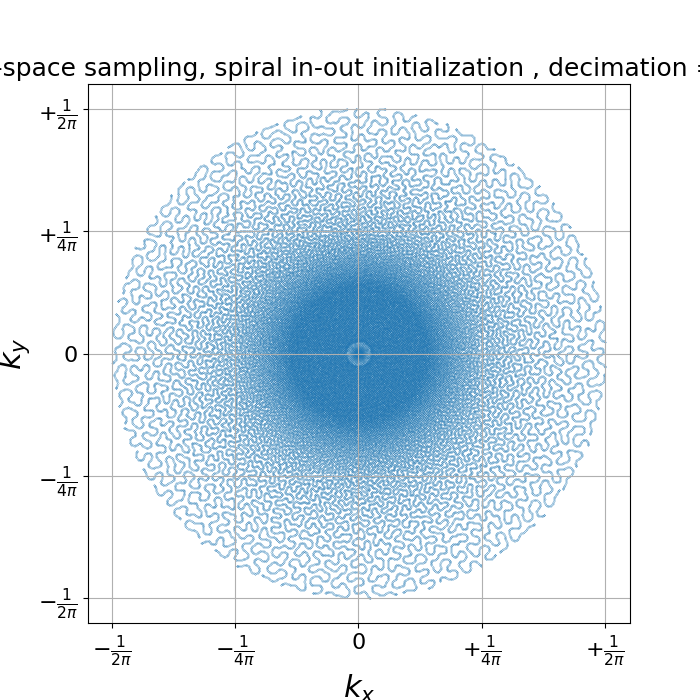

In [14]:
from scipy.io import loadmat

k_spark = loadmat(op.join(cwd, "..", "data","samples_SPARKLING_N512_nc34x3073_OS1.mat"))

k_spark_vec = k_spark['samples']

Kmax = np.amax(k_spark_vec)
print(Kmax)

k_spark_vec = k_spark_vec*1/(2*np.pi*Kmax)

k_spark = plt.figure(figsize=(7,7))
plt.scatter(k_spark_vec[:,0],k_spark_vec[:,1], marker = '.', s=0.1)
plt.grid()
#Figure layout

unit = 1/4
tick = np.arange(-0.5, 0.5 + unit, unit)

label = [r"$-\frac{1}{2\pi}$", r"$-\frac{1}{4\pi}$", r"$0$", r"$+\frac{1}{4\pi}$",  r"$+\frac{1}{2\pi}$"]

plt.xticks(tick/np.pi,labels = label, fontsize = 16) ; plt.yticks(tick/np.pi,labels = label, fontsize = 16)

plt.xlabel(r"$k_x$", fontsize = 22) ; plt.ylabel(r"$k_y$", fontsize = 22)

plt.title("K-space sampling, spiral in-out initialization , decimation = " 
          + str(samplingOptions.decim),fontsize = 18)

plt.show()

setting image dimension Nd... (512, 512)
setting spectrum dimension Kd... (512, 512)
setting interpolation size Jd... (6, 6)


<IPython.core.display.Javascript object>


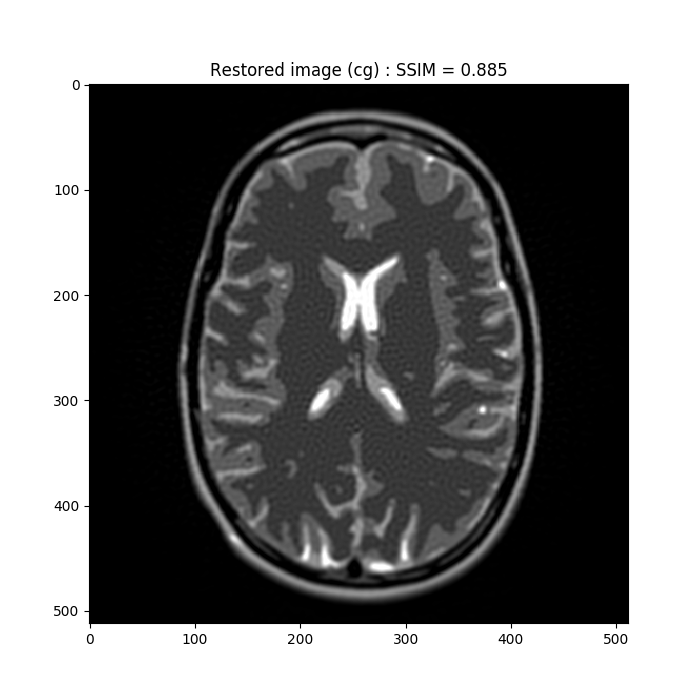

setting non-uniform data
y is an (M,) list <class 'numpy.ndarray'> (104482,)


In [21]:
from pynufft import NUFFT_cpu

NufftObj = NUFFT_cpu()

Nd = (img_size, img_size)  # image size
print('setting image dimension Nd...', Nd)
Kd = (img_size, img_size)  # k-space size
print('setting spectrum dimension Kd...', Kd)
Jd = (6, 6)  # interpolation size
print('setting interpolation size Jd...', Jd)

NufftObj.plan(k_spark_vec*2*np.pi, Nd, Kd, Jd)

mri_img = mri_img*1.0/np.max(mri_img) #image normalization

recons = plt.figure(figsize=(7,7))

y = NufftObj.forward(mri_img)
print('setting non-uniform data')
print('y is an (M,) list',type(y), y.shape)

image1 = NufftObj.solve(y, solver='cg',maxiter=50)

#SSIM
ssim_recon = ssim(mri_img, image1,data_range=mri_img.max() - image1.min())
ssim_recon = float(round(abs(ssim_recon),3))

plt.title('Restored image (cg) : SSIM = ' + str(ssim_recon.real))
plt.imshow(image1.real, cmap=matplotlib.cm.gray, norm=matplotlib.colors.Normalize(vmin=0.0, vmax=1))